In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('Figure_4', exist_ok=True)


# FIGURE 4
### Tissue maturity correlates with regional variation in cortical morphometry at birth
Make sure results from  `B__run_gene_models.py` and `E__genetic_age_prediction.py` are available

In [59]:
def pivot_bulk_data(data, values='log2_rpkm'):
    # select data
    selected_data = data.loc[:,['symbol', 'sample', 'region', 'age', values]]
    # pivot
    table_data = selected_data.pivot_table(index=['sample', 'region', 'age'], columns='symbol', values=values)
    table_data = table_data.reset_index()

    return table_data

/home/gball/PROJECTS/babyBrains/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


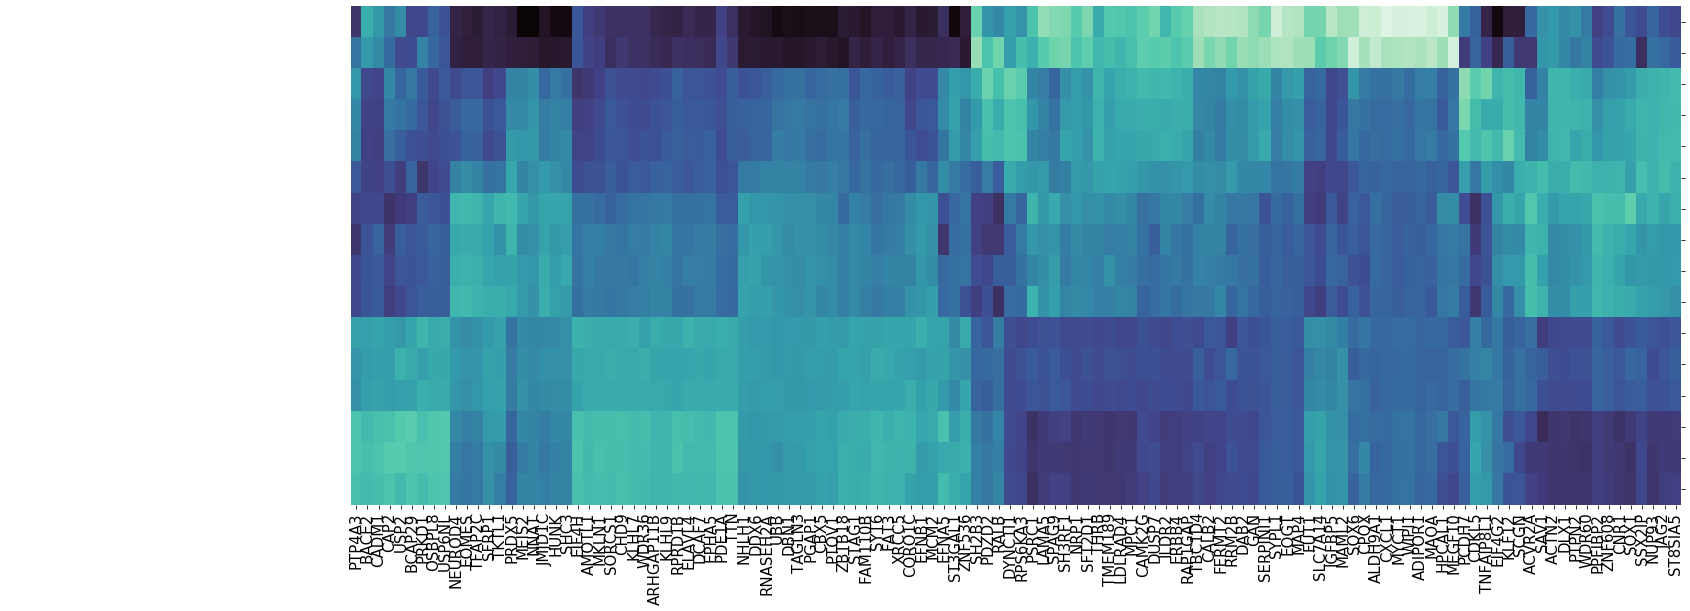

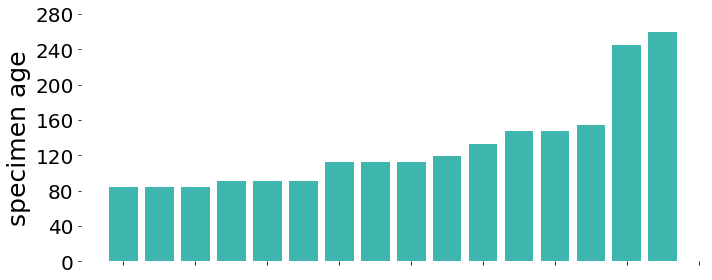

In [60]:
# FIGURE 4A
# load sample gene expression corrected for variance due to sex, RIN, and specimen ID
bulk_data = pd.read_csv('../results/gene_models/gene-data-corrected.csv')
# load significant gene list
significant_genes = pd.read_csv('../results/gene_correlations/PCA_correlations-KendallTau-PC-significant_genes-p0.05.csv')['symbol']

# pivot table
model_data = pivot_bulk_data(bulk_data, values='residuals')  # sample x genes

# normalise witin sample - relative expression of genes
normalised_model_data = model_data.copy()
normalised_significant_model_data = pd.concat((normalised_model_data[['sample','region','age']], normalised_model_data[significant_genes]), axis=1)

# plot expression as heatmap
dat = normalised_significant_model_data.groupby(['sample', 'age']).mean().reset_index().sort_values(by=['age'], ascending=False)
dat = dat.drop(['sample', 'age'], axis='columns')

g = sns.clustermap(dat, row_cluster=False, z_score=True, figsize=(30,10), cmap='mako')
g.ax_heatmap.tick_params('x', labelsize=15)
g.ax_heatmap.set_yticklabels([])
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
g.ax_heatmap.set_xlabel('')
plt.tight_layout()
# save
plt.savefig('Figure_4/Figure_4A.png')


# barplot
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.bar(x=np.arange(16),
       height=normalised_significant_model_data.groupby(['sample', 'age']).mean().reset_index().sort_values(by=['age'], ascending=True)['age'],
       color='#3fb6ad')
ax.set_xticklabels([''])
ax.set_yticks([0,40,80,120,160,200,240,280])
ax.set_yticklabels([0,40,80,120,160,200,240,280], fontsize=20)
ax.set_ylabel('specimen age', fontsize=25)
sns.despine(left=True, bottom=True)
plt.tight_layout()
# save
plt.savefig('Figure_4/Figure_4A-inset.png')


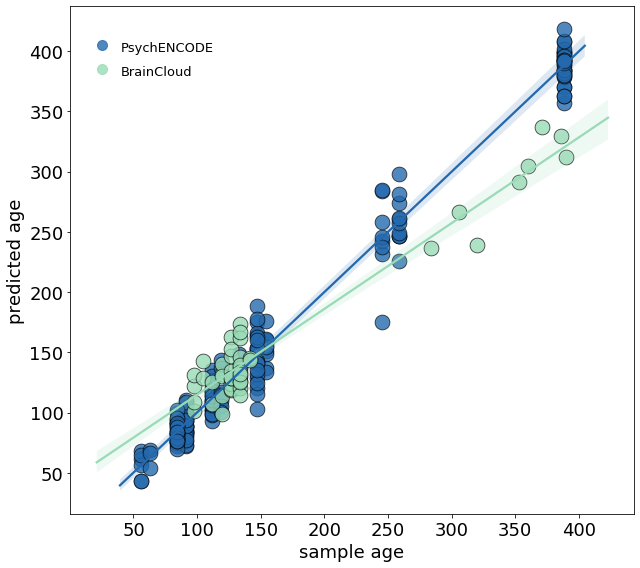

In [61]:
model_predictions = pd.read_csv('../results/age_predictions/age-prediction-significant_genes.csv')
model_correlations = pd.read_csv('../results/age_predictions/PC1-correlations-significant_genes.csv')
model_fits = pd.read_csv('../results/age_predictions/PC1-correlations-significant_genes-model-fits.csv')
validations_predictions = pd.read_csv('../results/age_predictions/age-prediction-BrainCloud-significant_genes.csv')

# SCATTERPLOT OF AGE PREDICTIONS IN TWO COHORTS
fig, ax = plt.subplots(1,1, figsize=(9,8))
sns.scatterplot('age', 'mean_prediction', data=model_predictions, color='#2469ad', s=220, edgecolor='black', alpha=.8, ax=ax)
sns.regplot('age', 'mean_prediction', data=model_predictions, color='#2469ad', scatter=False, units='region', ax=ax)
sns.scatterplot('age', 'mean_prediction', data=validations_predictions, color='#99dbb6', s=220, edgecolor='black', alpha=.8)
sns.regplot('age', 'mean_prediction', data=validations_predictions, color='#99dbb6', scatter=False, ax=ax)

ax.tick_params('both', labelsize=18)
ax.set_ylabel('predicted age', fontsize=18)
ax.set_xlabel('sample age', fontsize=18)

ax.text(40,400,'PsychENCODE', fontsize=13)
ax.text(40,380,'BrainCloud', fontsize=13)

plt.scatter([25],[405], color='#2469ad', s=100, alpha=.8)
plt.scatter([25],[385], color='#99dbb6', s=100, alpha=.8)
plt.tight_layout()
plt.savefig('Figure_4/Figure_4B.png')

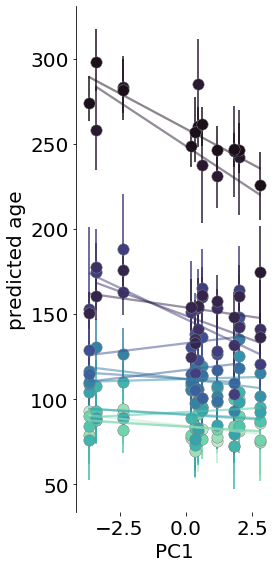

In [62]:
# AGE PREDICTIONS BY REGION AND SAMPLE
# select out prenatal samples
model_predictions = model_predictions[model_predictions.prenatal==1]
model_correlations = model_correlations[model_correlations['prenatal']==1]

# sort by age
sorted_samples = list(model_predictions.groupby(by='sample').mean().reset_index().sort_values(by='age')['sample'])
model_predictions = model_predictions.sort_values(by=['age', 'sample','region'])

# plot
g = sns.lmplot('PC', 'mean_prediction', data=model_predictions, hue='sample',
               palette='mako_r', truncate=True,
               line_kws={'alpha':0.5}, scatter_kws={'s':130, 'edgecolor':'grey', 'linewidths':.5, 'alpha':1},
               legend=False, ci=None, height=8, aspect=.5)

colors = sns.color_palette('mako_r', n_colors=len(sorted_samples))

# add error bars
for n, i in enumerate(sorted_samples):
    dat = model_predictions[model_predictions['sample']==i]
    err = dat['mean_prediction']-dat['lower_prediction'], dat['upper_prediction']-dat['mean_prediction']
    g.axes[0][0].errorbar(dat['PC'], dat['mean_prediction'], err, fmt='none', color=colors[n], zorder=0)

g.axes[0][0].tick_params('both', labelsize=20)
g.axes[0][0].set_ylabel('predicted age', fontsize=20)
g.axes[0][0].set_xlabel('PC1', fontsize=20)
sns.despine(bottom=True)

plt.tight_layout()
plt.savefig('Figure_4/Figure_4Ci.png')


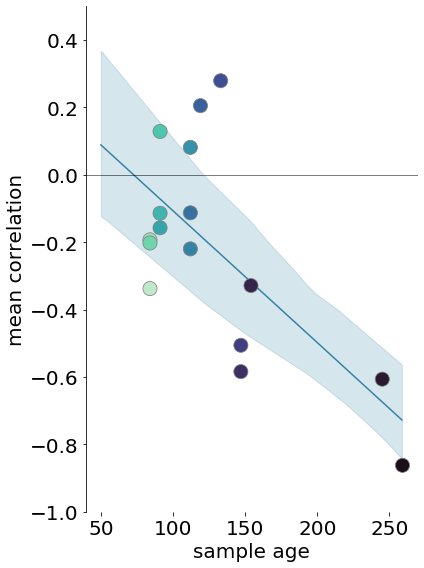

In [63]:
# Scatter of correlations with age
fig, ax = plt.subplots(1,1, figsize=(6,8))

hue_order = list(model_correlations.groupby(by='sample').mean().sort_values(by='age').index)
sns.scatterplot('age', 'mean_correlation', data=model_correlations,
                edgecolor='grey', s=200, hue='sample', legend=False,
                hue_order=hue_order, palette='mako_r', alpha=1, ax=ax)

ax.plot('age', 'prenatal_mean_fit', data=model_fits[model_fits['age']<260], color='#3483a5', zorder=0)
ax.fill_between('age', 'prenatal_lower_fit', 'prenatal_upper_fit', data=model_fits[model_fits['age']<260], alpha=0.2, zorder=0, color='#3483a5')

ax.tick_params('both', labelsize=20)
ax.set_ylabel('mean correlation', fontsize=20)
ax.set_xlabel('sample age', fontsize=20)
ax.set_ylim(-1,.5)
sns.despine(left=False, bottom=True)
ax.axhline(0, color='black', linestyle='-', lw=.5, zorder=0)

plt.tight_layout()
plt.savefig('Figure_4/Figure_4Cii.png')